Semantic Segmentation 
============

This jupyter notebook explores the task of image segmentation.
I am trying to reproduce the results in [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf), albeit as my dataset is much smaller I cannot match the accuracy reported in the paper

Using pytorch and a VGG16 pretrained network as the backbone of the algorithm (addidtional accuracy could be gained by training the full network). VGG16 is used as an encoder of information in the net, which is followed by a custom decoder.
This decoder is not purely sequential , but rather takes information from several of the convolutional layers, in order to base a decision on both local and global ppixel information.

Results are not very accurate, however I think the results are pretty good for a training dataset of 270 images.

MSRC-v2 Segmentation Dataset used. See data/segmentation_data/info.html



Initialisation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from data_utils import SegmentationData, label_img_to_rgb


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

SegmentationData is a custom dataset. See file, only basic transforms performed, no data augmentation.

In [2]:
train_data = SegmentationData(image_paths_file='segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file='segmentation_data/val.txt')

Vizualize data:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


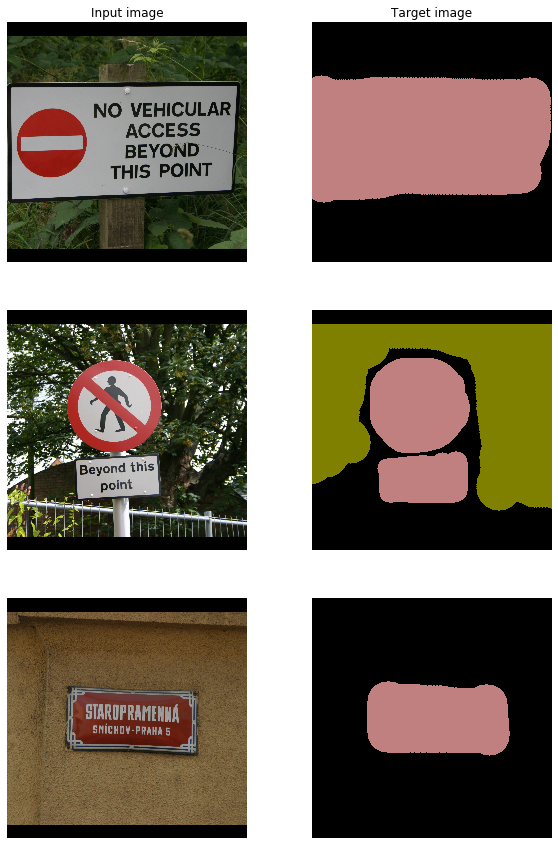

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

Training of the network. Please see SegmentationNN for more details on the model. Hyperparamaters manually tuned, bayesian hyperparameter optimization would have been nice..

In [4]:
from segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F


#make train dataset smaller for debugging purposes
train_data = train_data[:100]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=4)

model = SegmentationNN()
model.to(device)
solver = Solver(optim_args={"lr": 1e-4, "weight_decay": 0.001},
                loss_func=torch.nn.CrossEntropyLoss(size_average=True, ignore_index=-1))
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=40)

START TRAIN.


/u/halle/mot/home_at/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/u/halle/mot/home_at/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Epoch 1/41] TRAIN acc: 0.345420
[Epoch 1/41] VAL   acc: 0.188976
[Epoch 2/41] TRAIN acc: 0.438108
[Epoch 2/41] VAL   acc: 0.219425
[Epoch 3/41] TRAIN acc: 0.483678
[Epoch 3/41] VAL   acc: 0.234431
[Epoch 4/41] TRAIN acc: 0.510885
[Epoch 4/41] VAL   acc: 0.237535
[Epoch 5/41] TRAIN acc: 0.550920
[Epoch 5/41] VAL   acc: 0.246227
[Epoch 6/41] TRAIN acc: 0.568326
[Epoch 6/41] VAL   acc: 0.244271
[Epoch 7/41] TRAIN acc: 0.592113
[Epoch 7/41] VAL   acc: 0.244934
[Epoch 8/41] TRAIN acc: 0.602682
[Epoch 8/41] VAL   acc: 0.252191
[Epoch 9/41] TRAIN acc: 0.608796
[Epoch 9/41] VAL   acc: 0.253910
[Epoch 10/41] TRAIN acc: 0.618260
[Epoch 10/41] VAL   acc: 0.254727
[Epoch 11/41] TRAIN acc: 0.627752
[Epoch 11/41] VAL   acc: 0.257313
[Epoch 12/41] TRAIN acc: 0.630853
[Epoch 12/41] VAL   acc: 0.253202
[Epoch 13/41] TRAIN acc: 0.635448
[Epoch 13/41] VAL   acc: 0.258909
[Epoch 14/41] TRAIN acc: 0.639207
[Epoch 14/41] VAL   acc: 0.260602
[Epoch 15/41] TRAIN acc: 0.643744
[Epoch 15/41] VAL   acc: 0.26341

Testing. The accuracy metric is perhaps not very appropriate. An Intersection over unit metric would have probably been better. [Intersection over Union (IoU)](http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [5]:
test_data = SegmentationData(image_paths_file='segmentation_data_test/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.8263742317594833

Visualization of results:

159


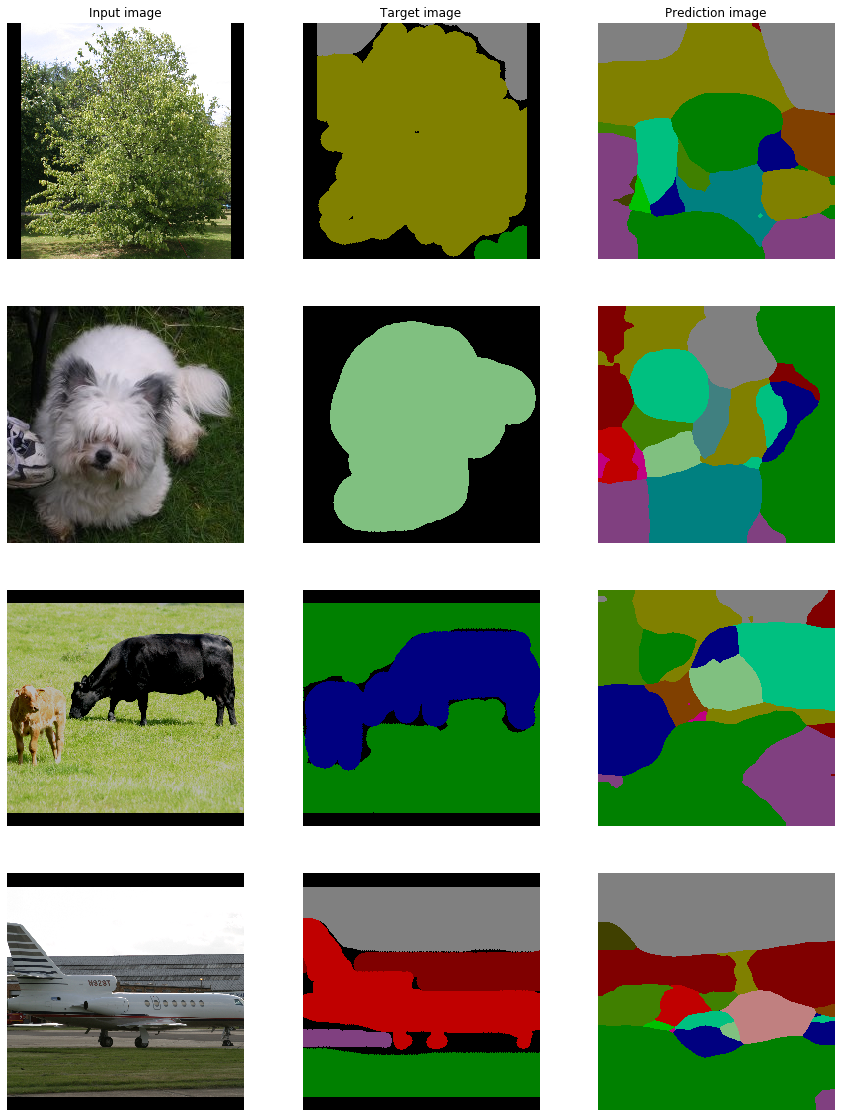

In [11]:
num_example_imgs = 4
dummy = np.random.choice(len(test_data))
print(dummy)
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[dummy:dummy+num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

Also vizualization of first convolutional layer weights:

(64, 3, 3, 3)


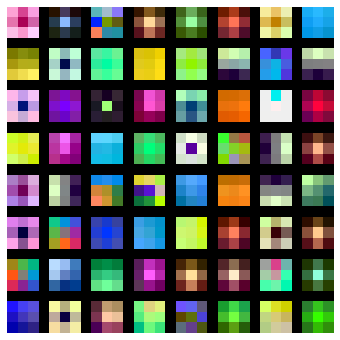

In [12]:
from vis_utils import visualize_grid

# first (next) parameter should be convolutional
iterator = model.parameters()
conv_params = next(iterator).data.cpu().numpy()
print(conv_params.shape)
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6,6 )
plt.show()

